In [1]:
%reload_ext autoreload
%autoreload 2

import bispectrum_3D_numba as b3n

import interpolated_quantities_numba as iqn

import numba

import matplotlib.pyplot as plt
#retina display
%config InlineBackend.figure_format = 'retina'

import temperatureinfo as ti

import numpy as np

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


## Checking bispectrum

In [371]:
import integrated_bispectrum
import scipy.integrate as sinteg

@np.vectorize
def integrate_bispectrum_kkk(l1, l2, l3, angle12, angle13, angle23, model = 'TR'):
    bispectrum_at_ells_of_chi = lambda chi: chi**(-4)*integrated_bispectrum.Wkk(chi)**3*integrated_bispectrum.bispectrum_matter(l1/chi, l2/chi, l3/chi, angle12, angle13, angle23, integrated_bispectrum.zofchi(chi), model = model)
    #return sinteg.quadrature(bispectrum_at_ells_of_chi, 0, integrated_bispectrum.chistar, maxiter = 50, rtol = 1e-8)[0]
    return sinteg.quadrature(bispectrum_at_ells_of_chi, 1e-12, integrated_bispectrum.chistar, maxiter = 100, miniter = 50, rtol = 1e-12)[0]

In [372]:
ls = np.arange(2, 4000, 1).astype(np.float64)

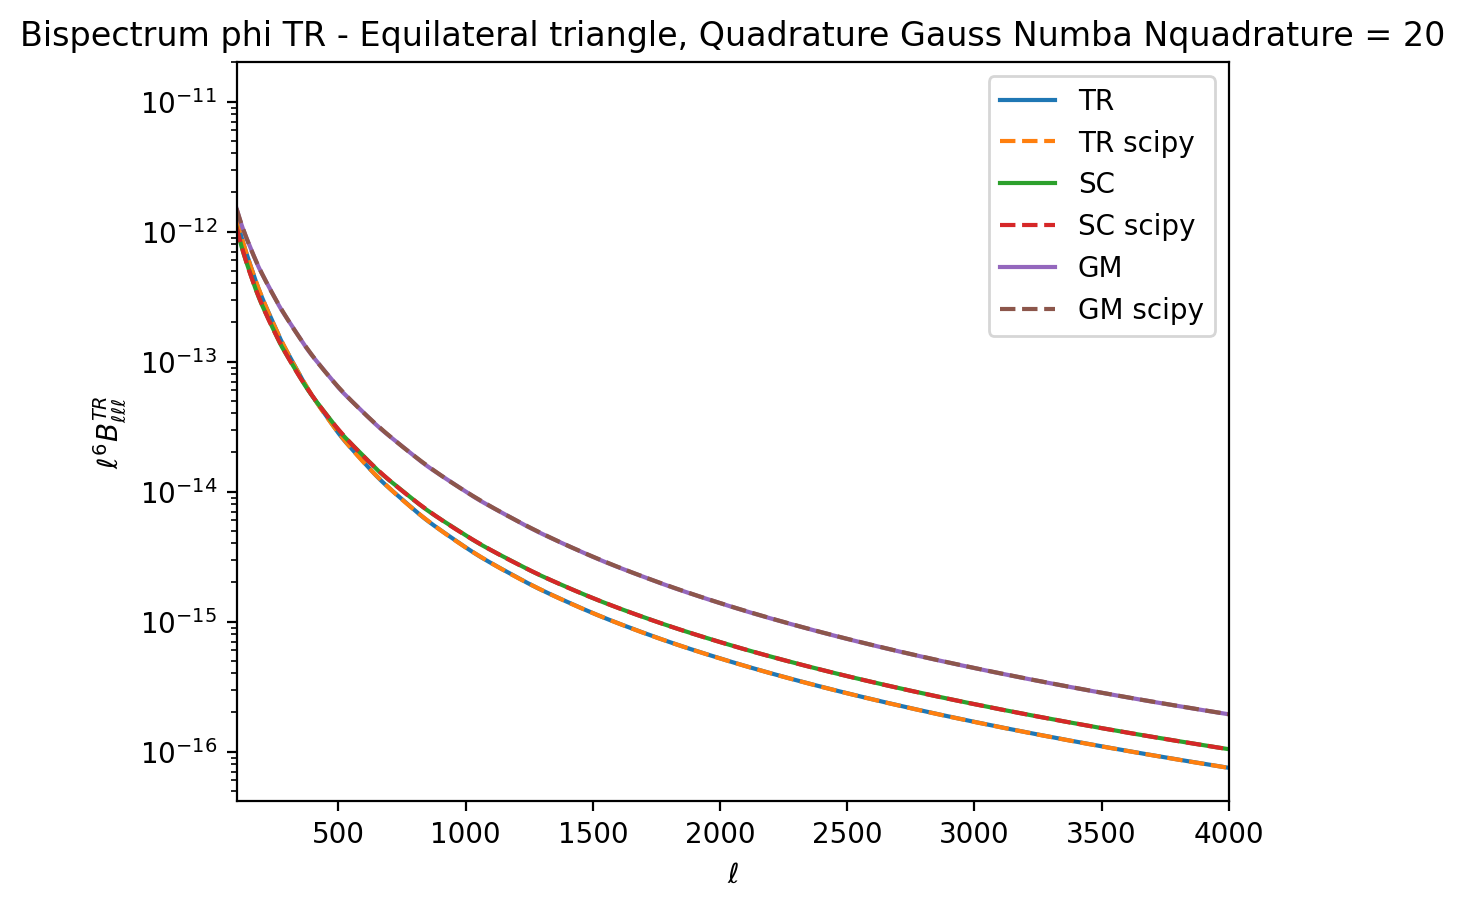

In [370]:
plt.title(f"Bispectrum phi TR - Equilateral triangle, Quadrature Gauss Numba Nquadrature = {b3n.Nquadrature}")
#for N in [10, 20, 30, 40]:
#    plt.plot(ls, ls**6*b3n.bispec_check_quadrature(ls, ls, ls, N), label = f"Quadrature Gauss Numba Nquadrature = {N}")
#plt.plot(ls, ls**6*b3n.bispec_phi_TR(ls, ls, ls), label = f"TR")
#plt.plot(ls, ls**6*b3n.bispec_phi_GM(ls, ls, ls), label = f"GM")

models = ['TR', 'SC', 'GM']
for i, model in enumerate(models):
    angle12, angle13, angle23 = np.pi/3, np.pi/3, np.pi/3
    calculated = 8/(ls**3)**2*integrate_bispectrum_kkk(ls, ls, ls, angle12, angle13, angle23, model = model)#list(map(integrate_bispectrum_kkk_single, ls))
    plt.plot(ls, ls**6*b3n.bispec_phi_general(ls, ls, ls, i), label = f"{model}")
    plt.plot(ls, calculated*ls**6, label = model+" scipy", ls = '--')

plt.yscale("log")
plt.ylabel(r"$\ell^6 B_{\ell\ell\ell}^{TR}$")
plt.xlabel(r"$\ell$")
plt.xlim(100, 4000)
#plt.loglog(ls, b3n.integrate_bispectrum_kkk_TR_cos_scipy_from_triangle(ls, ls, ls), label = "Scipy")
plt.legend()

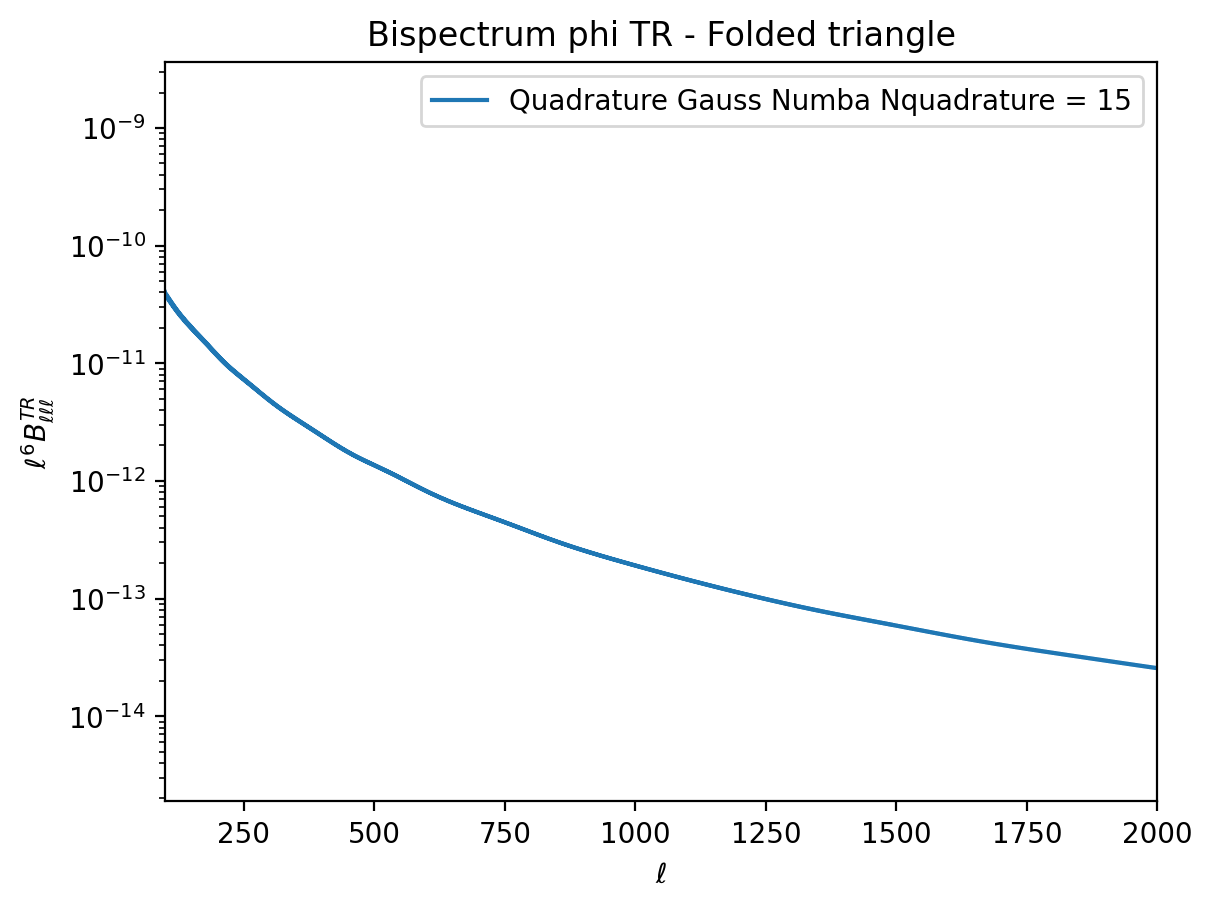

In [4]:
plt.title("Bispectrum phi TR - Folded triangle")
plt.plot(ls, ls**6*b3n.bispec_phi_TR(ls, ls//2, ls//2), label = f"Quadrature Gauss Numba Nquadrature = {b3n.Nquadrature}")
plt.yscale("log")
plt.ylabel(r"$\ell^6 B_{\ell\ell\ell}^{TR}$")
plt.xlabel(r"$\ell$")
plt.xlim(100, 4000)
#plt.loglog(ls, b3n.integrate_bispectrum_kkk_TR_cos_scipy_from_triangle(ls, ls, ls), label = "Scipy")
plt.legend()

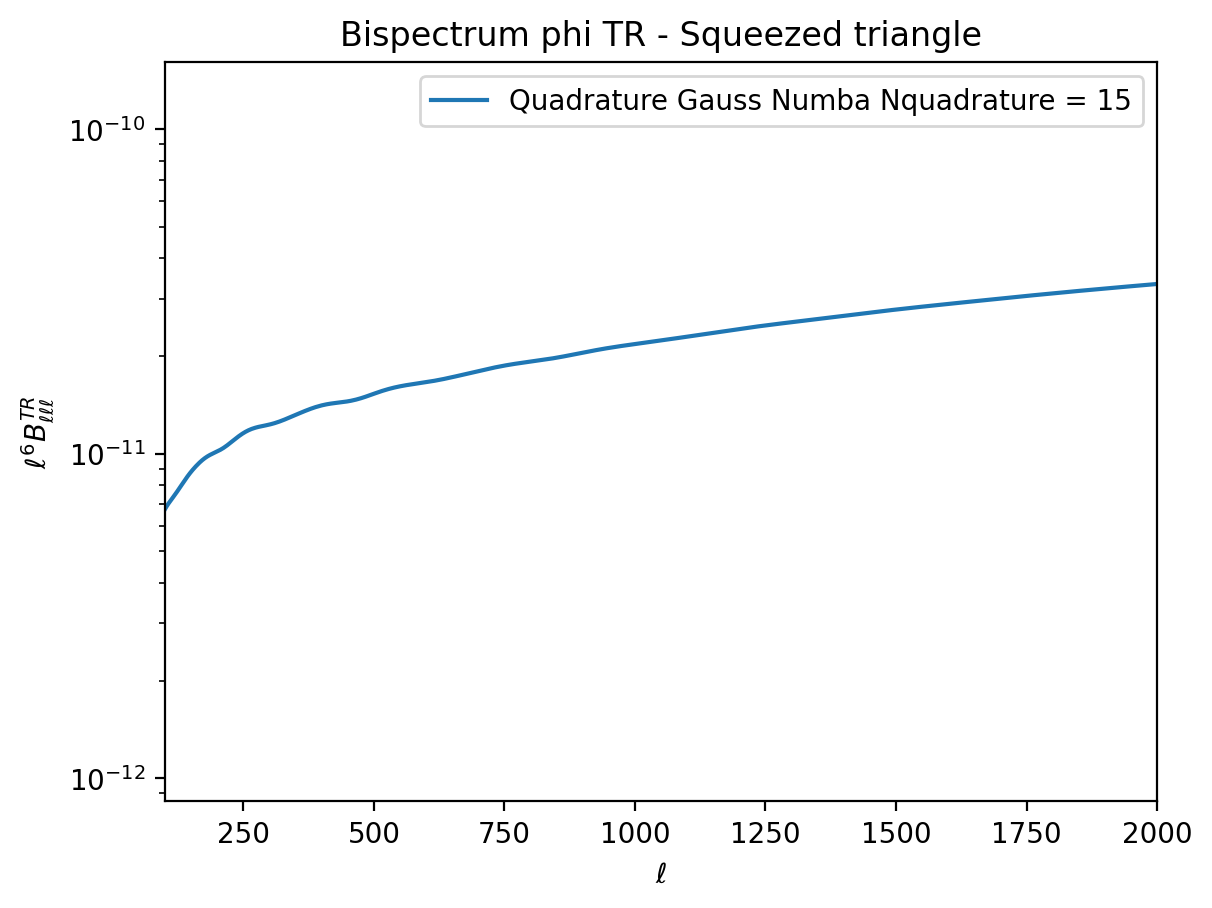

In [5]:
plt.title("Bispectrum phi TR - Squeezed triangle")
ls0 = 50
plt.plot(ls, ls**6*b3n.bispec_phi_TR(ls0, ls, ls), label = f"Quadrature Gauss Numba Nquadrature = {b3n.Nquadrature}")
plt.yscale("log")
plt.ylabel(r"$\ell^6 B_{\ell\ell\ell}^{TR}$")
plt.xlabel(r"$\ell$")
plt.xlim(100, 4000)
#plt.loglog(ls, b3n.integrate_bispectrum_kkk_TR_cos_scipy_from_triangle(ls, ls, ls), label = "Scipy")
plt.legend()

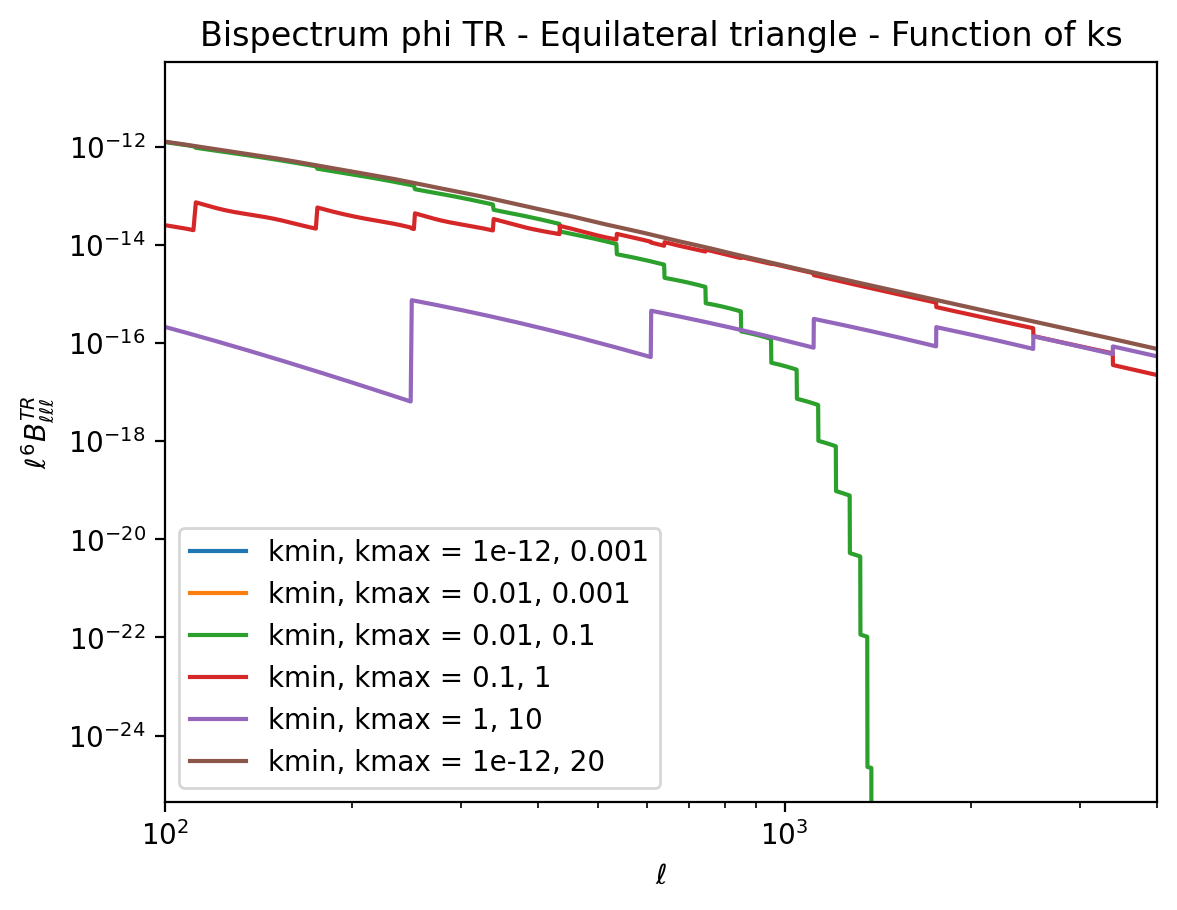

In [183]:
@np.vectorize
def bispec_phi_TR_non_vec_for_k(l1, l2, l3, kmin, kmax):
    return b3n.bispec_phi_TR_non_vec_for_k(l1, l2, l3, kmin, kmax)

plt.title("Bispectrum phi TR - Equilateral triangle - Function of ks")
kmin, kmax = 1, 100
for kmin, kmax in zip([1e-12, 1e-2, 1e-2, 1e-1, 1, 1e-12], [1e-3, 1e-3, 1e-1, 1, 10, 20]):
    plt.plot(ls, ls**6*bispec_phi_TR_non_vec_for_k(ls, ls, ls, kmin, kmax), label = f"kmin, kmax = {kmin}, {kmax}")
plt.yscale("log")
plt.ylabel(r"$\ell^6 B_{\ell\ell\ell}^{TR}$")
plt.xlabel(r"$\ell$")
plt.xlim(100, 4000)
plt.xscale("log")
#plt.loglog(ls, b3n.integrate_bispectrum_kkk_TR_cos_scipy_from_triangle(ls, ls, ls), label = "Scipy")
plt.legend()

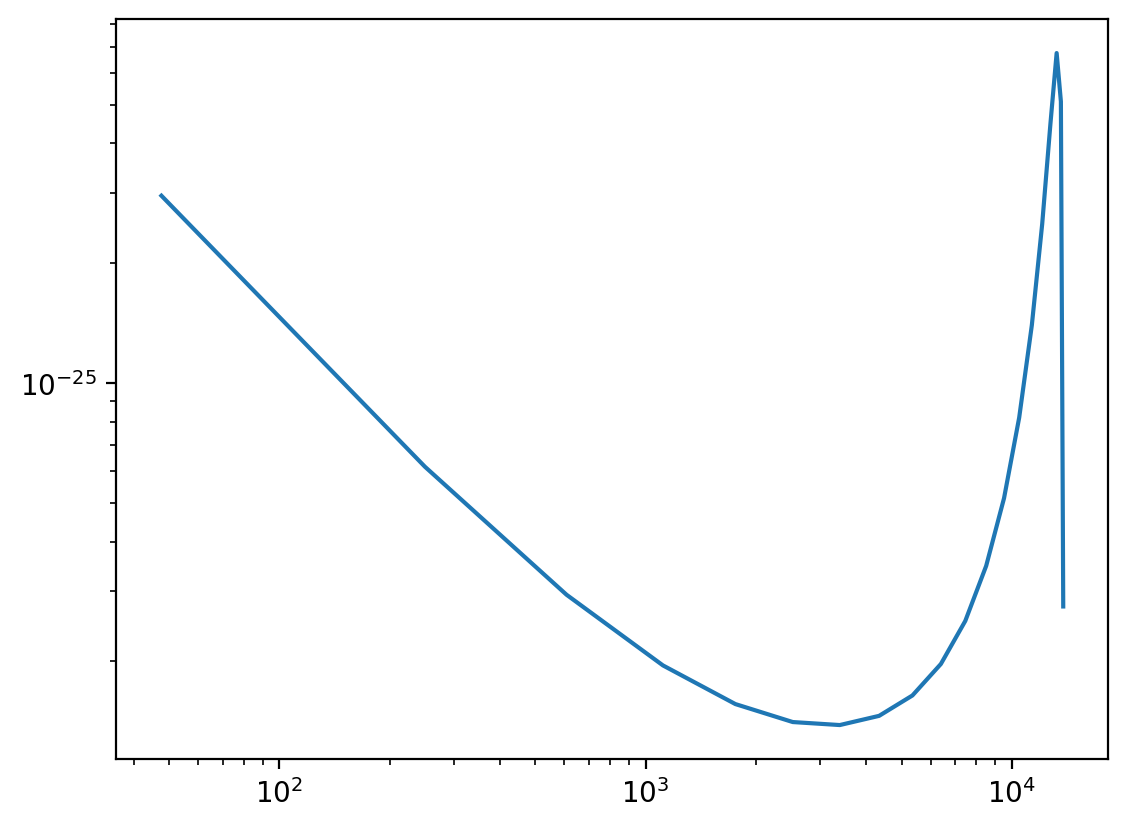

In [185]:
plt.loglog(b3n.xsgauss, b3n.chipow_4_times_Wkk3_pre_calc)

## Check CMB experiment

In [6]:
import scipy as sp

In [231]:
lmin, lmax = 10, 4000
print("lmin, lmax", lmin, lmax)
noise, beam = 1., 1.
uTT, lTT, tTT, gTT = ti.get_interpolated(lmin, lmax)

lmin, lmax 10 4000


In [232]:
def dot(a, b):
    return np.dot(a, b)

def fTT(l1v, l2v, l1n, l2n):
    return dot(l1v+l2v, l1v)*lTT(l1n)+dot(l1v+l2v, l2v)*lTT(l2n)

def ftotTT(l):
    return tTT(l)

@numba.jit
def filters(ells):
    return (ells>=lmin) & (ells<=lmax)

def gTT(lv, Lv, lvnorm):
    l1v, l2v = lv, Lv-lv
    l1n, l2n = lvnorm, np.linalg.norm(l2v, axis = 0)
    return fTT(l1v, l2v, l1n, l2n)/(2*ftotTT(l1n)*ftotTT(l2n))#*filters(l1n)*filters(l2n)

In [245]:
from interpolation import interp

@numba.jit(nopython = True)
def uTTinterp(l):
    return interp(ti.L, ti.unlensed, l) 

@numba.jit(nopython = True)
def lTTinterp(l):
    return interp(ti.L, ti.lensed, l) 

@numba.jit(nopython = True)
def gTTinterp(l):
    return interp(ti.L, ti.gradTT, l) 

noise_component = ti.get_noise(ti.L, noise, beam)
@numba.jit(nopython = True)
def tTTinterp(l):
    return interp(ti.L, ti.lensed+noise_component, l) 

#lTT = sp.interpolate.interp1d(ti.L, ti.lensed, fill_value = 0., bounds_error = False)
#tTT = sp.interpolate.interp1d(ti.L, ti.lensed+ti.get_noise(L, noise, beam), fill_value = 1e10, bounds_error = False)

In [252]:
#get points and weights for Gaussian quadrature using numpy legendre module
def gaussxw(a, b, N):
    x, w = np.polynomial.legendre.leggauss(N)
    return 0.5*(b-a)*x + 0.5*(b+a), 0.5*(b-a)*w

@numba.jit(nopython = True, fastmath = True)
def get_integral_for_AL(L, lmin, lmax, l2res = 10, xgauss = None, wgauss = None):

    l2s = np.linspace(lmin, lmax, l2res) if xgauss is None else xgauss

    dl = np.float(l2s.max()-l2s.min())/np.float(len(l2s))

    integralL = np.empty(l2s.shape, dtype = np.float64)
    integralLgradresp = np.empty(l2s.shape, dtype = np.float64)

    for i2, l2 in enumerate(l2s):

        ntheta2 =  max(32,2*int(l2)+1) 
        ntheta2 = min(ntheta2, 512) 
        dtheta2 = (2*np.pi/ntheta2)
        theta2s = np.linspace(0, 2*np.pi, ntheta2)
        
        cos2s = np.cos(theta2s)

        weight2 = l2/(2*np.pi)**2
        l4 = np.sqrt(L**2+l2**2 -2*L*l2*cos2s)

        response = ((-L*l2*cos2s + L**2)*lTTinterp(l4) + (L*l2*cos2s)*lTTinterp(l2)) 
        responsegrad = ((-L*l2*cos2s + L**2)*gTTinterp(l4) + (L*l2*cos2s)*gTTinterp(l2)) 
        
        filter = 1/(2*tTTinterp(l2)*tTTinterp(l4))
        filter[l4<lmin] = 0
        filter[l4>lmax] = 0 

        gTT = response*filter
        gTTgrad = responsegrad*filter

        somma = np.trapz(gTT*response, theta2s)
        sommagrad = np.trapz(gTTgrad*responsegrad, theta2s)

        integralL[i2] = somma*weight2
        integralLgradresp[i2] = sommagrad*weight2

    result = np.sum(integralL*wgauss) if xgauss is not None else np.sum(integralL)*dl
    resultgrad = np.sum(integralLgradresp*wgauss) if xgauss is not None else np.sum(integralLgradresp)*dl
    return result, resultgrad


In [253]:
Nquadrature = 200
l2gauss, w2gauss = gaussxw(lmin, lmax, Nquadrature)

In [254]:
Nquadrature = 200
l2gauss, w2gauss = gaussxw(lmin, lmax, Nquadrature)
AA, AAgrad = get_integral_for_AL(10, lmin, lmax, l2res = 10, xgauss = l2gauss, wgauss = w2gauss)
Nquadrature = 500
l2gauss, w2gauss = gaussxw(lmin, lmax, Nquadrature)
BB, BBgrad = get_integral_for_AL(10, lmin, lmax, l2res = 10, xgauss = l2gauss, wgauss = w2gauss)
print(AA/BB-1)
print(AAgrad/BBgrad-1)
print(AA/AAgrad-1)

0.0004038875864718072
5.6659360606614584e-05
0.09975967633045801


In [249]:
Ls = np.linspace(20, 4000, 40)

In [263]:
Nquadrature = 500
l2gauss, w2gauss = gaussxw(lmin, lmax, Nquadrature)

In [264]:
Amatrix = np.array([get_integral_for_AL(LL, lmin, lmax, l2res = 2000, xgauss = l2gauss, wgauss = w2gauss) for LL in Ls])
ALsanall, ALsanal = Amatrix.T

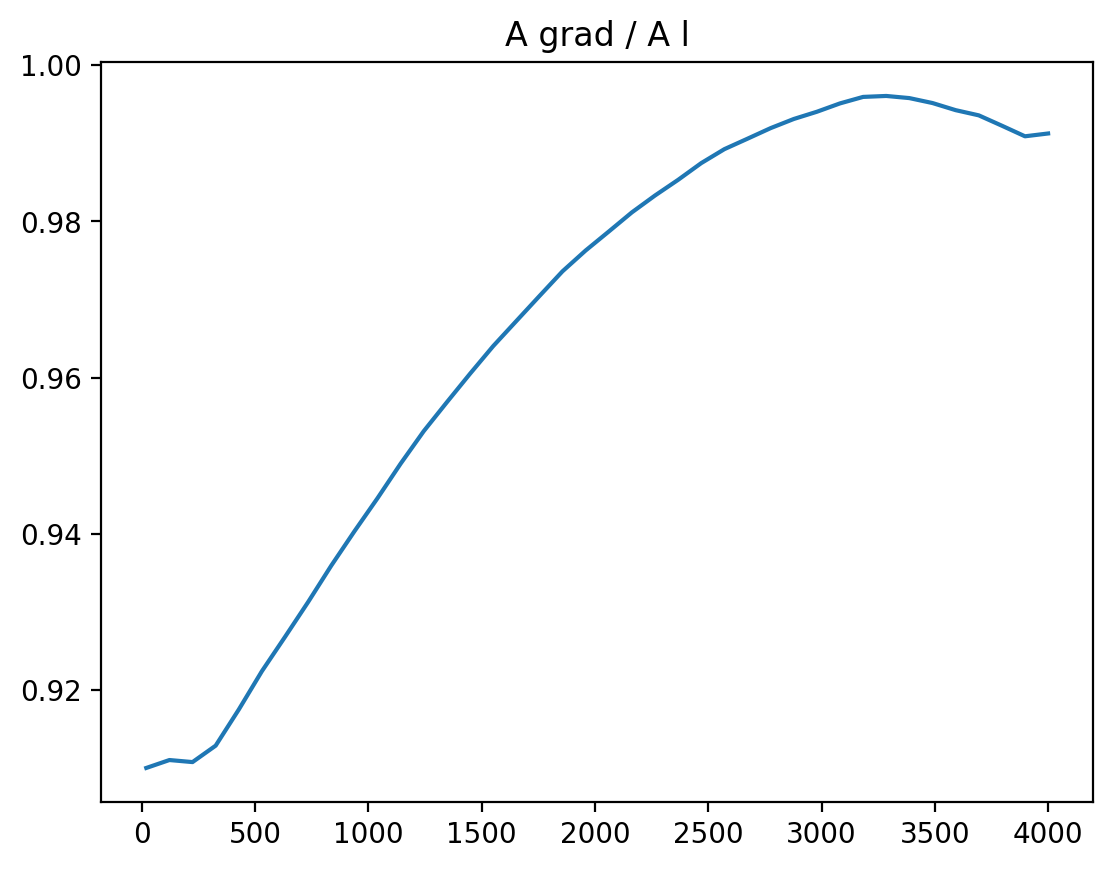

In [265]:
plt.title("A grad / A l")
plt.plot(Ls, ALsanal/ALsanall)

In [208]:
l, potential = np.loadtxt('/Users/omard/Downloads/potential_from_camb_demuni.txt', unpack = True)
ppinterp = np.interp(Ls, l, potential)

### Getting $N^{3/2}$ analytical

In [443]:
@numba.jit(nopython = True, fastmath = True, parallel = True)
def get_integral_for_L(L, lmin, lmax, l1res = 10, l2res = 10, theta1par = 512, theta2par = 512,
                       l1gauss = None, w1gauss = None, l2gauss = None, w2gauss = None,
                       thet1gauss = None, wthet1gauss = None, thet2gauss = None, wthet2gauss = None, index = 0):

    eps = 1e-4
    epsilonl = 1e-6

    integralL = 0.

    l1s = np.linspace(lmin, lmax, l1res) if l1gauss is None else l1gauss
    dl1 = np.float(lmax-lmin)/np.float(l1res)

    l2s = np.linspace(lmin, lmax, l2res) if l2gauss is None else l2gauss

    dl2 = np.float(lmax-lmin)/np.float(l2res)

    N1s = l1s.shape[0]
    N2s = l2s.shape[0]

    integral1 = np.empty(N1s, dtype = np.float64)

    for i in numba.prange(N1s):
        
        l1 = l1s[i]

        ntheta1 =  max(32, 2*int(l1)+1) 
        ntheta1 = min(ntheta1, theta1par) 
        dtheta1 = (2*np.pi/ntheta1)
        theta1s = np.linspace(eps, 2*np.pi-eps, ntheta1) if thet1gauss is None else thet1gauss
        
        integraltheta1 = np.empty(theta1s.shape, dtype = np.float64)
    
        for it1 in numba.prange(ntheta1):
            theta1 = theta1s[it1]

            cos1 = np.cos(theta1)
            sin1 = np.sin(theta1)
            l3 = np.sqrt(L**2+l1**2-2*L*l1*cos1)+epsilonl
    
            #weight1 = dtheta1*l1/(2*np.pi)**2
            weight1 = l1/(2*np.pi)**2
    
            bispectrum_term = b3n.bispec_phi_general_non_vec(l1, l3, L, index)

            integral2 = np.empty(l2s.shape, dtype = np.float64)
            
            for i2 in numba.prange(N2s):
                
                l2 = l2s[i2]

                ntheta2 =  max(32,2*int(l2)+1) 
                ntheta2 = min(ntheta2, theta2par) 
                dtheta2 = (2*np.pi/ntheta2)
                theta2s = np.linspace(eps, 2*np.pi-eps, ntheta2) if (thet2gauss is None) else thet2gauss
                
                Cl2 = gTTinterp(l2) #uTTinterp(l2)
            
                cos2s = np.cos(theta2s)
                sin2s = np.sin(theta2s)

                #weight2 = dtheta2*l2/(2*np.pi)**2*dl2
                weight2 = l2/(2*np.pi)**2

                l4 = np.sqrt(L**2+l2**2 -2*L*l2*cos2s)+epsilonl
                l5 = np.sqrt((l1*cos1-l2*cos2s)**2+(l1*sin1-l2*sin2s)**2)+epsilonl

                Cl5 = gTTinterp(l5) #uTTinterp(l5)
                
                Cl5[l5 > lmax] = 0
                Cl5[l5 < lmin] = 0

                #gTT = np.empty(theta2s.shape, dtype = np.float64)
                #gTT[(l4<lmin) & (l4>lmax)] = 0
                #selection = (l4>lmin) & (l4<lmax)
                
                l4_dot_L = (-L*l2*cos2s + L**2)
                l2_dot_L = (L*l2*cos2s)

                response = (l4_dot_L*gTTinterp(l4) + l2_dot_L*gTTinterp(l2)) 
                filter = 1/(2*tTTinterp(l2)*tTTinterp(l4))
                #gTT[selection] = response*filter
                
                filter[l4<lmin] = 0
                filter[l4>lmax] = 0 
                gTT = response*filter

                l1_dot_l2 = (l1*cos1*l2*cos2s) + (l1*sin1*l2*sin2s)
                l2_dot_l3 = l2_dot_L-l1_dot_l2
                l5_dot_l1 = l1**2-l1_dot_l2
                l5_dot_l3 = L*l1*cos1-l2_dot_L-l1**2+l1_dot_l2

                A1terms = -l5_dot_l1*l5_dot_l3*1*1*Cl5*gTT
                C1terms = l2_dot_l3*l1_dot_l2*1*1*Cl2*gTT*2*1/2

                somma = np.trapz(A1terms+C1terms, theta2s)*weight2 if wthet2gauss is None else np.dot(A1terms+C1terms, wthet2gauss)*weight2

                integral2[i2] = somma

            integral2 = np.trapz(integral2, l2s) if w2gauss is None else np.dot(integral2, w2gauss)
            integral2 *= bispectrum_term
            integraltheta1[it1] = integral2
            integral1[i] = np.trapz(integraltheta1, theta1s) if wthet1gauss is None else np.dot(integraltheta1, wthet1gauss)*weight1
            #weight1*integral2*bispectrum_term
            #integral2*bispectrum_term
    integralL = np.trapz(integral1, l1s) if w1gauss is None else np.dot(integral1, w1gauss)
    return integralL

            
            
        


In [444]:
get_integral_for_L(3000, lmin, lmax, l1res = 10, l2res = 10, index = 1)

-0.0001474411958454595

In [445]:
get_integral_for_L(3000, lmin, lmax, l1res = 10, l2res = 10, index = 1)

-0.0001474411958454595

In [446]:
get_integral_for_L(3000, lmin, lmax, l1res = 10, l2res = 10)

-0.00011842191191649106

In [434]:
get_integral_for_L(3000, lmin, lmax, l1res = 10, l2res = 10, theta1par=128, theta2par=256)

-0.0002537383626896564

In [465]:
Nquadrature = 160
l1gauss, w1gauss = gaussxw(lmin, lmax, Nquadrature)

Nquadrature = Nquadrature*2
l2gauss, w2gauss = gaussxw(lmin, lmax, Nquadrature)

AA = get_integral_for_L(1020, lmin, lmax, l1res = 10, l2res = 10, l1gauss = l1gauss, w1gauss = w1gauss, l2gauss = l2gauss, w2gauss = w2gauss, theta1par=128, theta2par=256)

Nquadrature = 40*2
l1gauss, w1gauss = gaussxw(lmin, lmax, Nquadrature)

Nquadrature = Nquadrature//2
l2gauss, w2gauss = gaussxw(lmin, lmax, Nquadrature)

BB = get_integral_for_L(1020, lmin, lmax, l1res = 10, l2res = 10, l1gauss = l1gauss, w1gauss = w1gauss, l2gauss = l2gauss, w2gauss = w2gauss, theta1par=128, theta2par=256)

print(AA/BB)

0.973527666688375


In [436]:
Nquadraturetheta = 40
thet1gauss, wthet1gauss = gaussxw(0, 2*np.pi, Nquadraturetheta)
thet2gauss, wthet2gauss = thet1gauss, wthet1gauss

Nquadrature = 40
l1gauss, w1gauss = gaussxw(lmin, lmax, Nquadrature)

Nquadrature = Nquadrature//2
l2gauss, w2gauss = gaussxw(lmin, lmax, Nquadrature)

In [437]:
print("lmin, lmax", lmin, lmax)
result_analytical = np.array([get_integral_for_L(LL, lmin, lmax, l1res = 50, l2res = 20, l1gauss = l1gauss, w1gauss = w1gauss, l2gauss = l2gauss, w2gauss = w2gauss, theta1par = 128, theta2par = 256) for LL in Ls])

lmin, lmax 10 4000


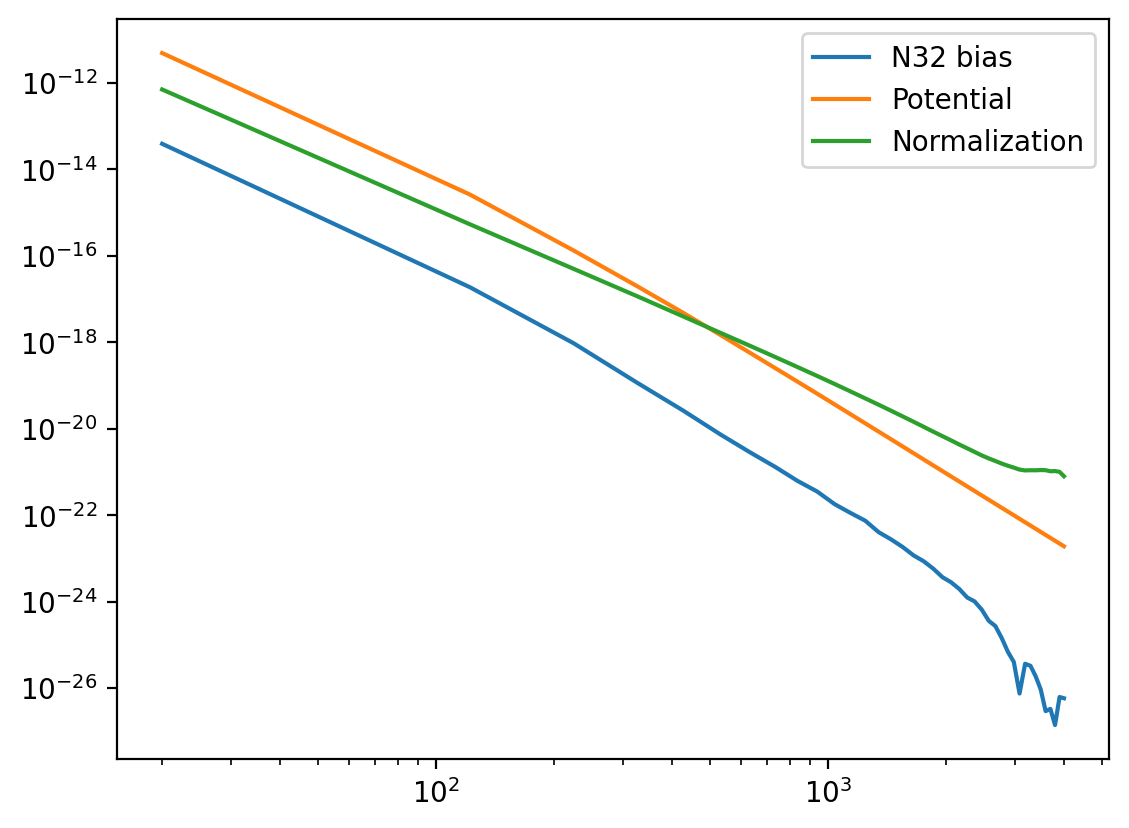

In [438]:
plt.loglog(Ls, abs(np.array(result_analytical)*ALsanal**-1), label = "N32 bias")
plt.loglog(Ls, ppinterp, label = "Potential")
plt.loglog(Ls, ALsanal**-1, label = "Normalization")
plt.legend()

(20.0, 4199.0)

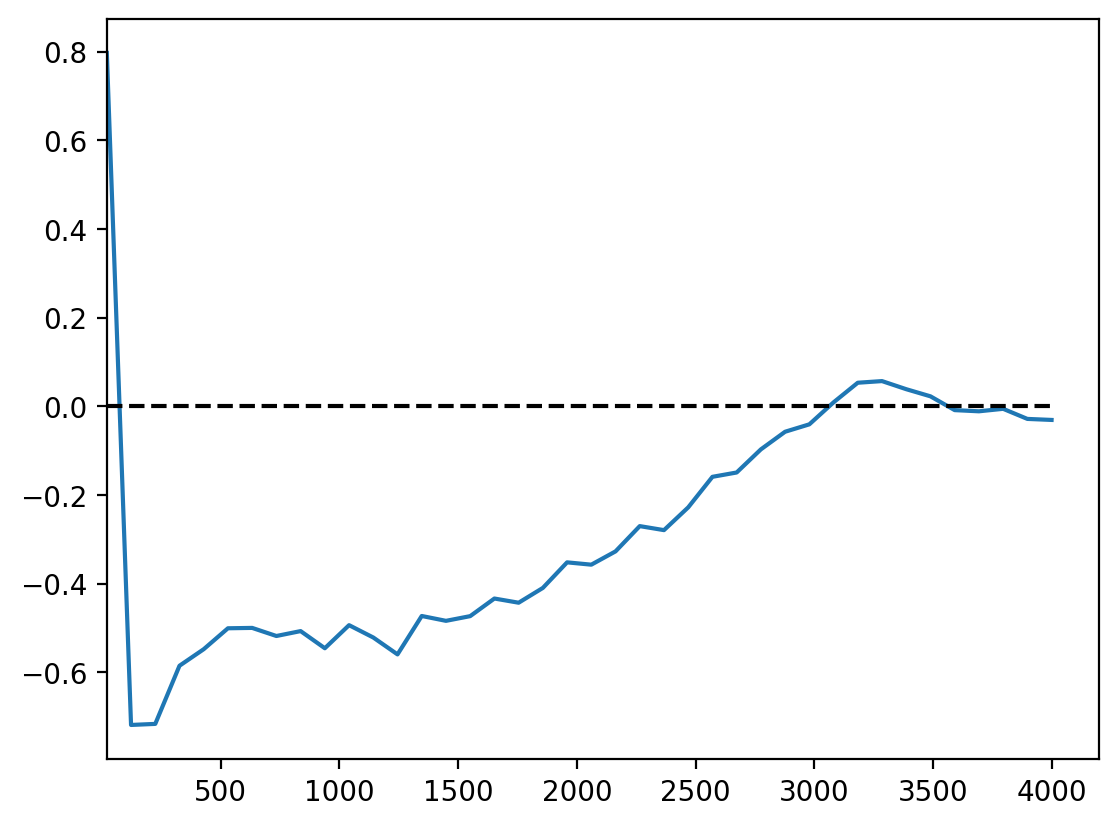

In [466]:
ppinterp = np.interp(Ls, ti.l, ti.pp)
plt.plot(Ls, (result_analytical)*ALsanal**-1./ppinterp*100)
plt.plot(Ls, Ls*0., "k--")
plt.xlim(20)

## Use Vegas for the integration

In [451]:
lmin, lmax = 10, 4000
print("lmin, lmax", lmin, lmax)
noise, beam = 1., 1.
uTT, lTT, tTT, gTT = ti.get_interpolated(lmin, lmax, noise, beam)

lmin, lmax 10 4000


In [452]:
import vegas

In [507]:
def dotbatch(a, b):
    return a[0, :]*b[0, :]+a[1, :]*b[1, :]

    
def funlTTbatch(l1v, l2v, l1n, l2n):
    Lv = l1v+l2v
    return dotbatch(Lv, l1v)*uTT(l1n)+dotbatch(Lv, l2v)*uTT(l2n)

def flenTTbatch(l1v, l2v, l1n, l2n):
    Lv = l1v+l2v
    return dotbatch(Lv, l1v)*lTT(l1n)+dotbatch(Lv, l2v)*lTT(l2n)

def fgradTTbatch(l1v, l2v, l1n, l2n, gradientTT):
    Lv = l1v+l2v
    return dotbatch(Lv, l1v)*gradientTT(l1n)+dotbatch(Lv, l2v)*gradientTT(l2n)

def ftotTTfTTbatch(l):
    return tTT(l)

def gfTTbatch(lv, Lv, l1n, l2n, gradientTT):
    l1v, l2v = lv, Lv-lv
    return fgradTTbatch(l1v, l2v, l1n, l2n, gradientTT)/(2*ftotTTfTTbatch(l1n)*ftotTTfTTbatch(l2n))

def gfTTbatch_for_modes(l1v, l2v, l1n, l2n, gradientTT):
    return fgradTTbatch(l1v, l2v, l1n, l2n, gradientTT)/(2*ftotTTfTTbatch(l1n)*ftotTTfTTbatch(l2n))

### Get normalization to check the vegas code

In [454]:
filter_batch = lambda x: (x >= lmin) & (x <= lmax)

In [508]:
def get_AL_MC(Ls, gradientTT):
    integ = vegas.Integrator([[lmin, lmax], [0, 2*np.pi]])
    nitn, neval = 100, 1e3

    ALMC = []

    for LL in Ls:
        @vegas.batchintegrand
        def integrand(x):
            l1, theta1 = x.T
            l1v = np.array([l1*np.cos(theta1), l1*np.sin(theta1)])
            L = np.ones_like(l1)*LL
            Lv = np.c_[L, np.zeros_like(l1)].T
            l3v = Lv-l1v

            l3 = np.linalg.norm(l3v, axis = 0)

            fXY = fgradTTbatch(l1v, l3v, l1, l3, gradientTT)

            gXY = gfTTbatch_for_modes(l1v, l3v, l1, l3, gradientTT)*filter_batch(l3)

            product = fXY*gXY     
            common = l1/(2*np.pi)**2

            return product*common
        
        result = integ(integrand, nitn = nitn, neval = neval)
        ALMC += [result.mean]

    ALMC = np.array(ALMC)**-1.

    return ALMC



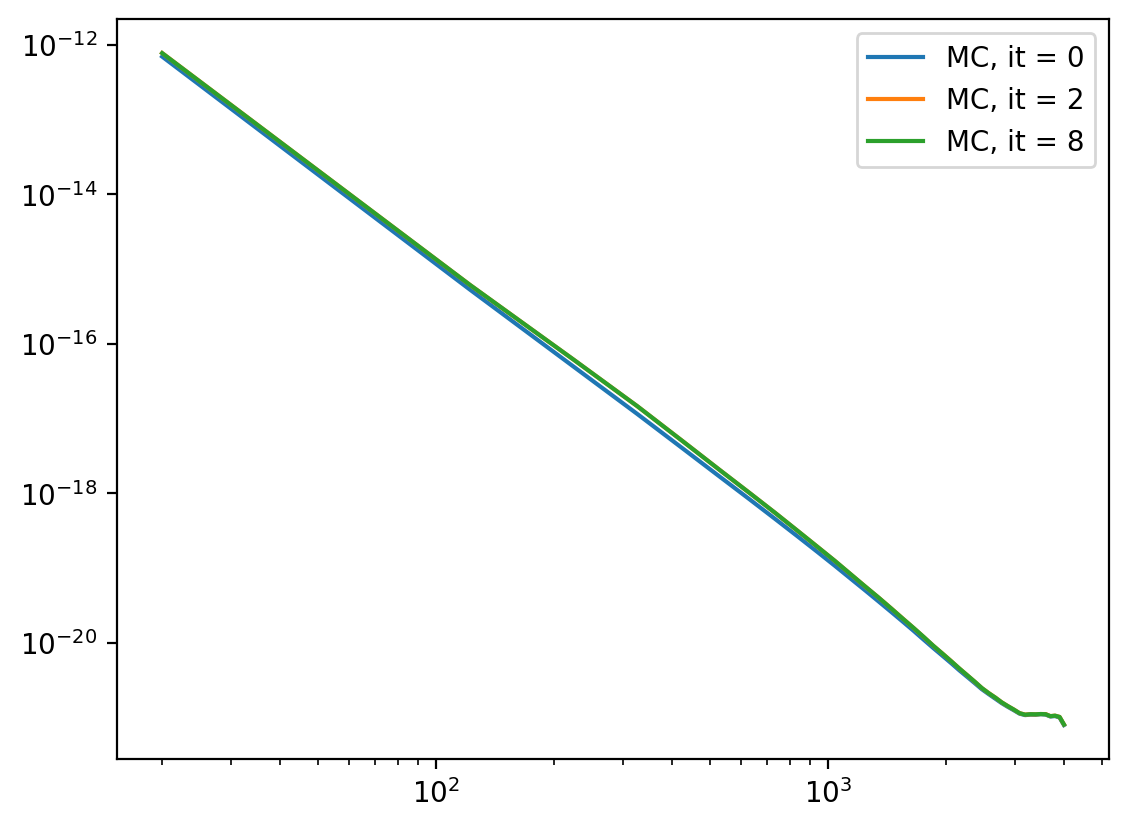

In [511]:
casi = np.load("casi.npy", allow_pickle = True).item()

ALMCS = {}
for it in [0, 2, 8]:
    gradTT_it = casi[it]
    gTT_it = sp.interpolate.interp1d(ti.elgrad, gradTT_it[2:,0], fill_value = 0., bounds_error = False)
    gradientTT = gTT_it
    ALMC_ = get_AL_MC(Ls, gradientTT)
    if i == 0:
        ALMC = ALMC_
    ALMCS[it] = ALMC_

for it in [0, 2, 8]:
    plt.loglog(Ls, ALMCS[it], label = "MC, it = %d"%it)
plt.legend()

In [456]:
cents, Alphi = ti.get_norm(lmin, lmax, noise, beam)

/Users/omard/Documents/projects/fgcmblensing/bispectrum/temperatureinfo.py:60: RuntimeWarning: invalid value encountered in divide
  Alkappa = modlmap**4*1/integral/4
/Users/omard/Documents/projects/symlens/symlens/utils.py:170: RuntimeWarning: invalid value encountered in divide
  res = np.bincount(self.digitized,(data2d).reshape(-1))[1:-1]/np.bincount(self.digitized)[1:-1]
/Users/omard/Documents/projects/symlens/symlens/utils.py:170: RuntimeWarning: invalid value encountered in divide
  res = np.bincount(self.digitized,(data2d).reshape(-1))[1:-1]/np.bincount(self.digitized)[1:-1]


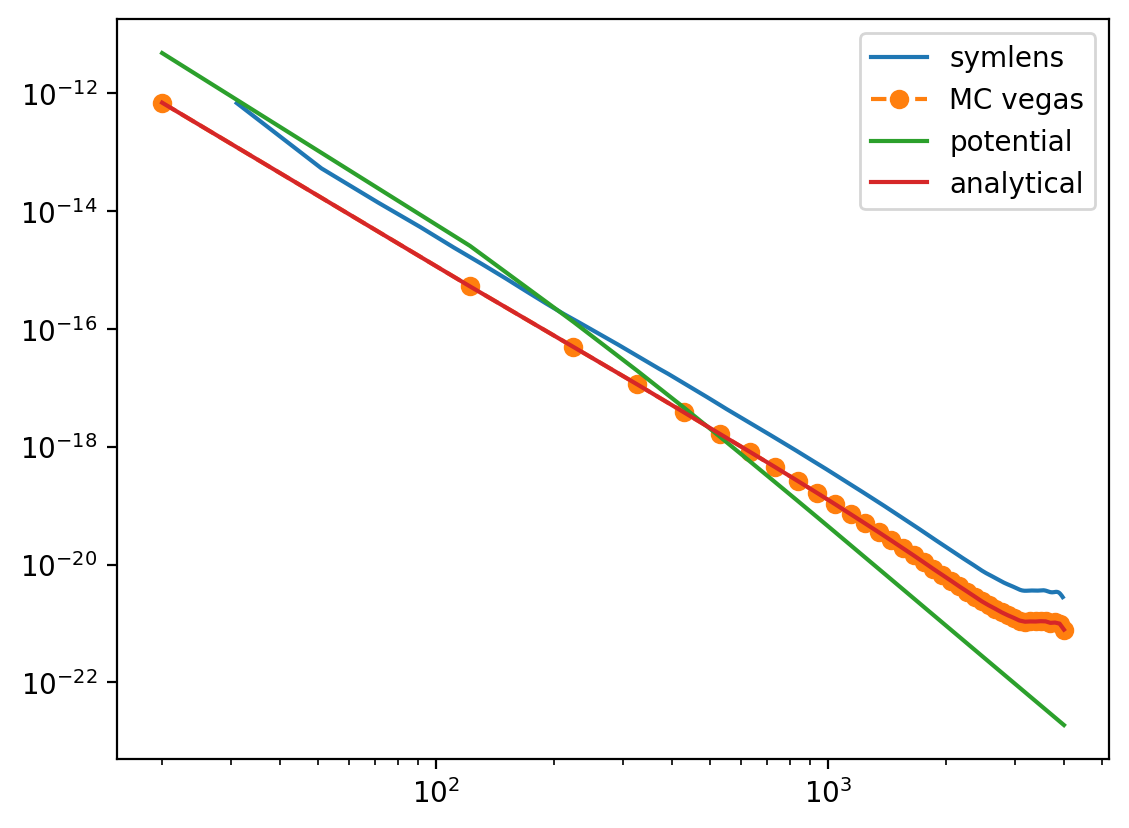

In [457]:
plt.loglog(cents, Alphi, label = "symlens")

plt.loglog(Ls, ALMC, ls = "--", marker = 'o', label = "MC vegas")
plt.loglog(Ls, ppinterp, label = "potential")
#plt.loglog(cents, Alphi)
plt.loglog(Ls, ALsanal**-1., label = "analytical")

#plt.loglog(Ls, np.array([get_integral_for_AL(LL, lmin, lmax, l2res = res, xgauss = l2gauss, wgauss = w2gauss) for LL in Ls])**-1., ls = '--', label = f"res = Gauss")
plt.legend()

### Now get the $N^{(3/2)}$ bias

In [474]:
integ = vegas.Integrator([[lmin, lmax], [lmin, lmax], [0, 2*np.pi], [0, 2*np.pi]], nhcube_batch = 2000)
nitn, neval = 1e1, 1e3

In [500]:
casi = np.load("casi.npy", allow_pickle = True).item()
gradTT_it = casi[8]
gTT_it = sp.interpolate.interp1d(ti.elgrad, gradTT_it[2:,0], fill_value = 0., bounds_error = False)
gradientTT = gTT_it

In [503]:
#model = "SC"
models = ["TR"]#, "SC"]#, "SC", "GM"]
#index = models.index(model)

results_n32 = {}

for index, model in enumerate(models):

    print("Working on model", model)

    NTOT = []

    for LL in Ls:
        @vegas.batchintegrand
        def integrand(x):
            l1, l2, theta1, theta2 = x.T
            cos1, cos2 = np.cos(theta1), np.cos(theta2)
            sin1, sin2 = np.sin(theta1), np.sin(theta2)
            
            l5 = l5 = np.sqrt((l1*cos1-l2*cos2)**2+(l1*sin1-l2*sin2)**2)
            l4 = np.sqrt(LL**2+l2**2 -2*LL*l2*cos2)
            l3 = np.sqrt(LL**2+l1**2-2*LL*l1*cos1)

            l4_dot_L = (-LL*l2*cos2 + LL**2)
            l2_dot_L = (LL*l2*cos2)

            response = (l4_dot_L*gradientTT(l4) + l2_dot_L*gradientTT(l2)) 
            filter = 1/(2*tTTinterp(l2)*tTTinterp(l4))
            gTTf = response*filter*filter_batch(l4)

            l1_dot_l2 = (l1*cos1*l2*cos2) + (l1*sin1*l2*sin2)
            l2_dot_l3 = l2_dot_L-l1_dot_l2
            l5_dot_l1 = l1**2-l1_dot_l2
            l5_dot_l3 = LL*l1*cos1-l2_dot_L-l1**2+l1_dot_l2

            cl5_XY = gradientTT(l5)*filter_batch(l5) #uTT(l5)*filter_batch(l5)
            Cl2 = gradientTT(l2)*filter_batch(l2) #uTT(l2)*filter_batch(l2)

            productA1 = -l5_dot_l1*l5_dot_l3*1*1*cl5_XY*gTTf
            productC1 = l2_dot_l3*l1_dot_l2*1*1*Cl2*gTTf*2*1/2

            bispectrum_result = b3n.bispec_phi_general(l1, l3, LL, index)

            common = l1*l2*bispectrum_result/(2*np.pi)**4

            #A1 = common*productA1
            #C1 = common*productC1
            result = (productA1+productC1)*common
            #return [common*productA1, common*productC1]
            return result #{'A1': common*productA1, 'C1': common*productC1}
        
        result = integ(integrand, nitn = nitn, neval = neval)
        NTOT += [result.mean]
        #NA1 += [result['A1'].mean]
        #NC1 += [result['C1'].mean]

    NTOT = np.array(NTOT)
    results_n32[model] = NTOT

Working on model TR


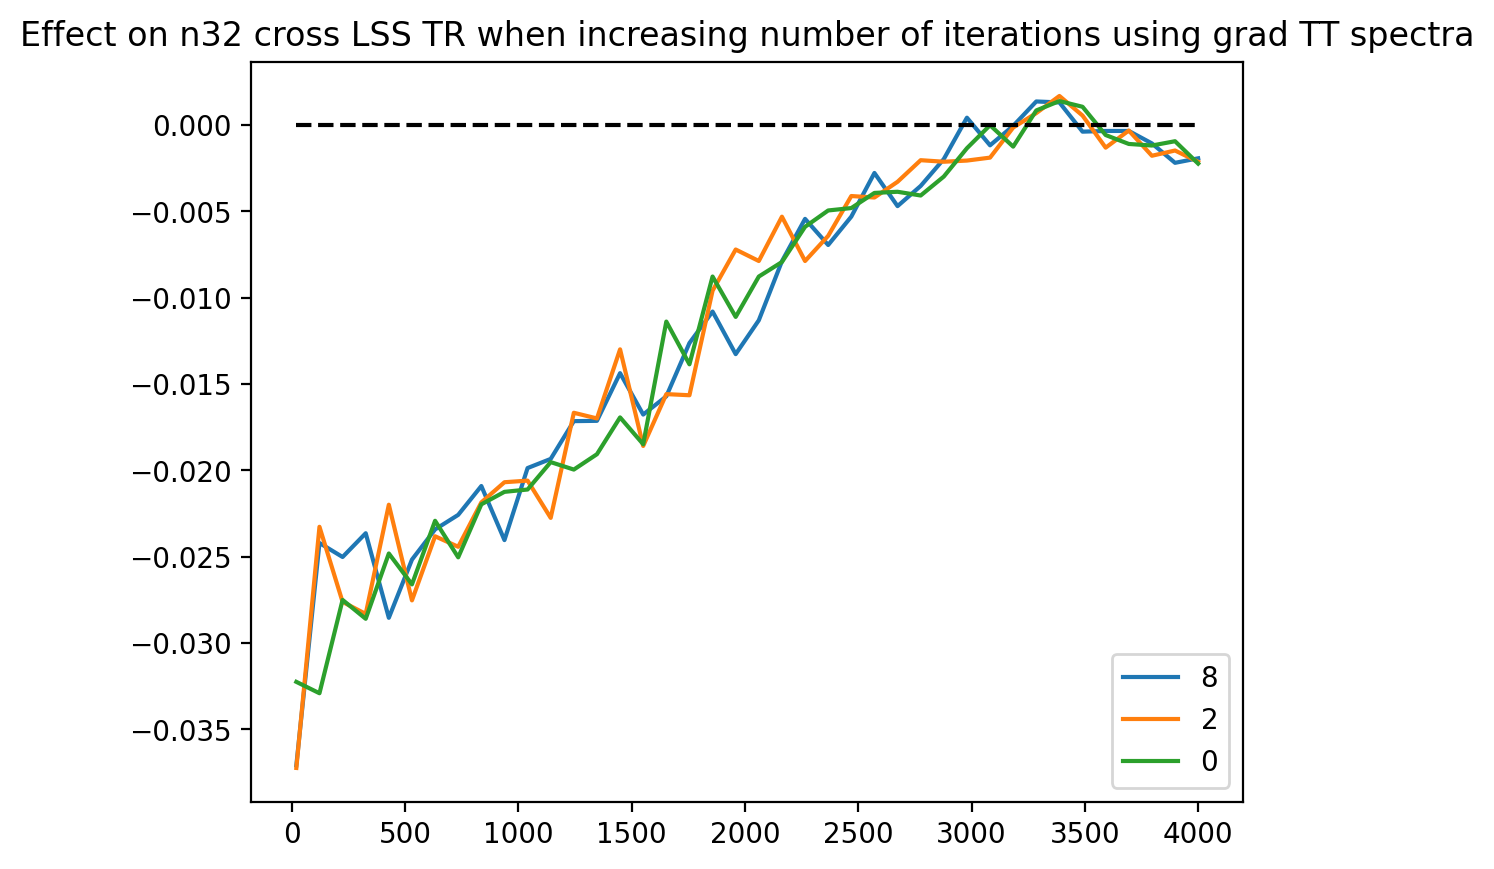

In [515]:
#iter2TR = results_n32[model]
plt.title("Effect on n32 cross LSS TR when increasing number of iterations using grad TT spectra")
iter8TR = results_n32["TR"]
plt.plot(Ls, ALMCS[8]*iter8TR/ppinterp, label = "8")
plt.plot(Ls, ALMCS[2]*iter2TR/ppinterp, label = "2")
plt.plot(Ls, ALMCS[0]*iter0TR/ppinterp, label = "0")
plt.plot(Ls, Ls*0., "k--")
plt.legend()

In [460]:
NA1 = []
NC1 = []

for LL in Ls:
    @vegas.batchintegrand
    def integrand(x):
        l1, l2, theta1, theta2 = x.T
        l1v, l2v = np.array([l1*np.cos(theta1), l1*np.sin(theta1)]), np.array([l2*np.cos(theta2), l2*np.sin(theta2)])
        L = np.ones_like(l1)*LL
        Lv = np.c_[L, np.zeros_like(l1)].T
        l3v = Lv-l1v
        l4v = Lv-l2v
        l5v = l1v-l2v

        l5 = np.linalg.norm(l5v, axis = 0)
        l4 = np.linalg.norm(l4v, axis = 0)
        l3 = np.linalg.norm(l3v, axis = 0)

        l5vdotl1v = dotbatch(l5v, l1v)
        l5vdotl3v = dotbatch(l5v, l3v)

        l2vdotl1v = dotbatch(l2v, l1v)
        l2vdotl3v = dotbatch(l2v, l3v)


        """cos1, cos2 = np.cos(theta1), np.cos(theta2)
        sin1, sin2 = np.sin(theta1), np.sin(theta2)
        l1_dot_l2 = (l1*cos1*l2*cos2) + (l1*sin1*l2*sin2)
        l2_dot_L = (LL*l2*cos2)
        l2_dot_l3 = l2_dot_L-l1_dot_l2
        l5vdotl1v = l1**2-l1_dot_l2
        l5vdotl3v = LL*l1*cos1-l2_dot_L-l1**2+l1_dot_l2"""

        h_5_2_X = 1
        h_5_4_Y = 1

        h_2_4_Y = 1
        h_2_4_X = 1
 
        cl5_XY = uTT(l5)#*filter_batch(l5)

        cl2_XY = uTT(l2)
        cl2_YX = cl2_XY

        gXY = gfTTbatch_for_modes(l2v, l4v, l2, l4)*filter_batch(l4)

        productA1 = (-1)*l5vdotl1v*l5vdotl3v*cl5_XY*h_5_2_X*h_5_4_Y*gXY

        #assume for now X = Y
        gYX = gXY 
        productC1 = 1/2*(gXY*cl2_XY*h_2_4_Y+gYX*cl2_YX*h_2_4_X)*l2vdotl1v*l2vdotl3v

        bispectrum_result = b3n.bispec_phi_TR(l1, l3, L)

        common = l1*l2*bispectrum_result/(2*np.pi)**4

        #A1 = common*productA1
        #C1 = common*productC1
        #return [common*productA1, common*productC1]
        return {'A1': common*productA1, 'C1': common*productC1}
    
    result = integ(integrand, nitn = nitn, neval = neval)
    NA1 += [result['A1'].mean]
    NC1 += [result['C1'].mean]

NA1 = np.array(NA1)
NC1 = np.array(NC1)

KeyboardInterrupt: 

In [334]:
ALinterp = ALMC#np.interp(Ls, cents, Alphi)
ppinterp = np.interp(Ls, ti.l, ti.pp)

In [335]:
#l, potential = np.loadtxt('/Users/omard/Downloads/potential_from_camb_demuni.txt', unpack = True)
#ppinterp = np.interp(Ls, l, potential)

TypeError: bad operand type for abs(): 'list'

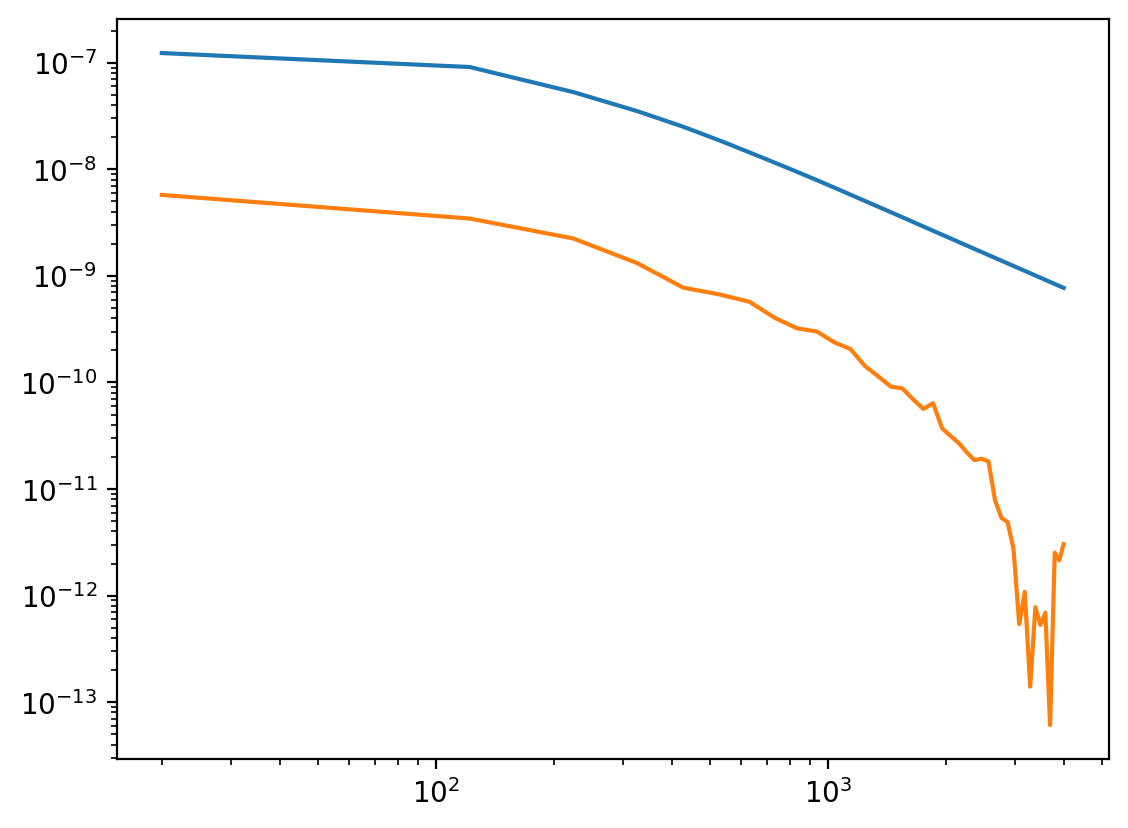

In [468]:
plt.loglog(Ls, Ls**4*ppinterp/2/np.pi, label = 'Theory pp')
#plt.loglog(l, l**4*potential/2/np.pi, label = 'Theory potential')
plt.loglog(Ls, Ls**4*ALinterp*abs(NTOT)/2/np.pi, label = 'N32 vegas alt')

plt.loglog(Ls, Ls**4*ALinterp*abs((NA1+NC1))/2/np.pi, label = 'N32 vegas')

plt.legend()
plt.ylabel(r"$L^4\mathcal{C}(L)/2\pi$")
plt.xlabel(r"$L$")
plt.xlim(20, 3000)

In [469]:
datafromsims = np.loadtxt("/Users/omard/Downloads/cross_n32_.txt")
elsims, n32qe = datafromsims[:, 0], datafromsims[:, 1]

In [470]:
from scipy import signal
import scipy

def bin_theory(l, lcl, bin_edges):
    sums = scipy.stats.binned_statistic(l, l, statistic = 'sum', bins = bin_edges)
    cl = scipy.stats.binned_statistic(l, lcl, statistic = 'sum', bins = bin_edges)
    cl = cl[0]/sums[0]
    return cl

bin_edges = np.arange(10, 4000, 140)

In [319]:
llinterp = np.arange(0, Ls.max(), 1)
from scipy.interpolate import InterpolatedUnivariateSpline
interpolating = InterpolatedUnivariateSpline(Ls, ALinterp**-1.*(NA1+NC1), ext = 1)
clbinned = bin_theory(llinterp, llinterp*interpolating(llinterp), bin_edges)

clppbinned = bin_theory(ti.l, ti.l*ti.pp, bin_edges)

In [389]:
#np.savetxt("n32TR.txt", np.c_[Ls, ALinterp*(NA1+NC1)])
#np.savetxt("n32SC.txt", np.c_[Ls, ALinterp*(NTOT)])

In [392]:
n32TR, n32SC = np.loadtxt("n32TR.txt")[:, 1], np.loadtxt("n32SC.txt")[:, 1]

In [ ]:
nbodykappa = np.loadtxt("kappa_first.txt")

(20.0, 3000.0)

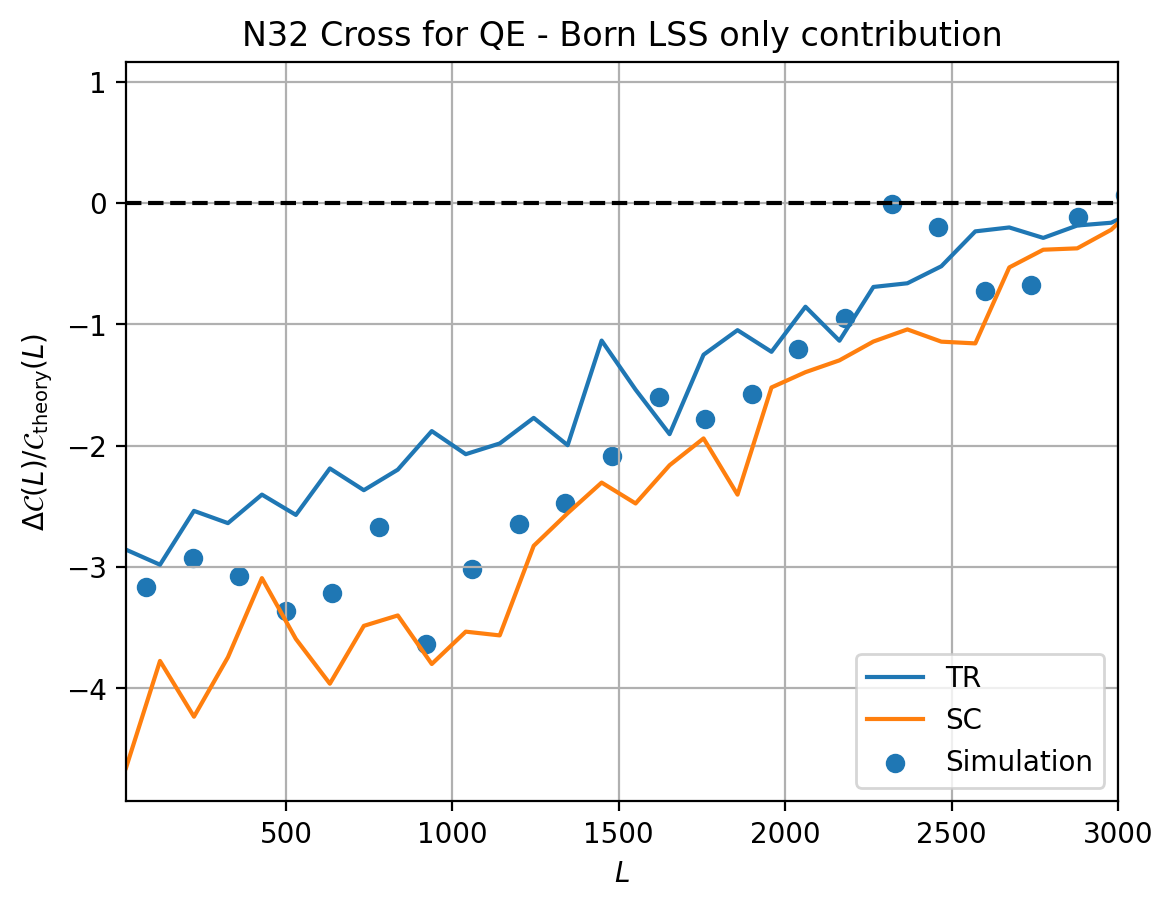

In [473]:
plt.title("N32 Cross for QE - Born LSS only contribution")
#plt.plot(Ls, (n32TR)/ppinterp*100, label = 'Analytical Bias TR')
#plt.plot(Ls, (n32SC)/ppinterp*100, label = 'Analytical Bias SC')

for k, v in results_n32.items():
    plt.plot(Ls, ALsanal**-1*v/ppinterp*100, label = k)

#plt.plot(elsims, clbinned/clppbinned*100)
plt.scatter(elsims, n32qe*100, label = 'Simulation')
plt.ylabel(r"$\Delta\mathcal{C}(L)/\mathcal{C}_{\rm theory}(L)$")
plt.plot(Ls, Ls*0, 'k--')
plt.xlabel(r"$L$")
plt.grid(True)
plt.legend()
plt.xlim(20, 3000)

In [ ]:
## check bias in function of noise